In [1]:
import pandas as pd
pd.set_option("display.max_row", 100)
pd.set_option("display.max_column", 100)
import numpy as np
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from lightgbm import LGBMRegressor

In [2]:
import pandas as pd

train = pd.read_csv("C:/Users/hu612/Desktop/School/sooda/Project/팀과제/민수서영우철/data/stk_hld_train.csv")
test = pd.read_csv("C:/Users/hu612/Desktop/School/sooda/Project/팀과제/민수서영우철/data/stk_hld_test.csv")
cus = pd.read_csv("C:/Users/hu612/Desktop/School/sooda/Project/팀과제/민수서영우철/data/cus_info.csv")
iem = pd.read_csv("C:/Users/hu612/Desktop/School/sooda/Project/팀과제/민수서영우철/data/iem_info_20210902.csv")
hist = pd.read_csv("C:/Users/hu612/Desktop/School/sooda/Project/팀과제/민수서영우철/data/stk_bnc_hist.csv")
submission = pd.read_csv("C:/Users/hu612/Desktop/School/sooda/Project/팀과제/민수서영우철/data/sample_submission.csv")

In [3]:
train.head(3)

,act_id,iem_cd,byn_dt,hold_d
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A006360,20180726,11
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005930,20180131,80
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005070,20180517,5


In [4]:
test.head(3)

,act_id,iem_cd,byn_dt,hist_d,submit_id,hold_d
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A032640,20200522,153,IDX00001,0
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A160600,20190823,335,IDX00002,0
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A234340,20200611,139,IDX00003,0


In [5]:
train["hist_d"] = train["hold_d"]*0.877
train.hist_d = np.trunc(train["hist_d"])

In [6]:
train

,act_id,iem_cd,byn_dt,hold_d,hist_d
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A006360,20180726,11,9.0
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005930,20180131,80,70.0
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005070,20180517,5,4.0
3,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A003520,20201112,22,19.0
4,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A002310,20180905,324,284.0
...,...,...,...,...,...
681467,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A260660,20180831,1,0.0
681468,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A271980,20201027,1,0.0
681469,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A289080,20181121,1,0.0
681470,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A307930,20200214,1,0.0


In [7]:
# train과 test에 고객정보(cus_info)와 주식정보(iem_info)를 추가하겠습니다.

train_data = pd.merge(train, cus, how = "left", on = ["act_id"])
train_data = pd.merge(train_data, iem, how = "left", on = ["iem_cd"])

test_data = pd.merge(test, cus, how = "left", on = ["act_id"])
test_data = pd.merge(test_data, iem, how = "left", on = ["iem_cd"])

In [8]:
train_data.shape

(681472, 18)

In [9]:
# train_data에서 Y값을 추출한 후 hold_d column을 지워주겠습니다.

train_label = train_data["hold_d"]
train_data.drop(["hold_d"], axis = 1, inplace = True)

In [10]:
# 추가적으로 약간의 전처리를 통해 train data와 test data를 구성하겠습니다.

hist["stk_p"] = hist["tot_aet_amt"] / hist["bnc_qty"]
hist = hist.fillna(0)

train_data = pd.merge(train_data, hist, how = "left", on = ["act_id", "iem_cd"])
train_data = train_data[(train_data["byn_dt"] == train_data["bse_dt"])]
train_data.reset_index(drop = True, inplace = True)

test_data = pd.merge(test_data, hist, how = "left", on = ["act_id", "iem_cd"])
test_data = test_data[(test_data["byn_dt"] == test_data["bse_dt"])]
test_data.reset_index(drop = True, inplace = True)

train_data = train_data.drop(["act_id", "iem_cd", "byn_dt", "bse_dt"], axis = 1)
test_data = test_data.drop(["act_id", "iem_cd", "byn_dt", "submit_id", "hold_d", "bse_dt"], axis = 1)

L_encoder = LabelEncoder()
L_encoder.fit(iem["iem_krl_nm"])
train_data["iem_krl_nm"] = L_encoder.transform(train_data["iem_krl_nm"])
test_data["iem_krl_nm"] = L_encoder.transform(test_data["iem_krl_nm"])

In [11]:
train_data.head(3)

,hist_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bnc_qty,tot_aet_amt,stk_par_pr,stk_p
0,9.0,1,9,3,2,2,9,5,5,8,101,1,1,1,274.0,11782000.0,5000.0,43000.0
1,70.0,1,9,3,2,2,9,5,5,8,1361,9,1,1,2.0,4990000.0,5000.0,2495000.0
2,4.0,1,9,3,2,2,9,5,5,8,2530,12,2,99,786.0,14619600.0,1000.0,18600.0


In [12]:
train_data

,hist_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bnc_qty,tot_aet_amt,stk_par_pr,stk_p
0,9.0,1,9,3,2,2,9,5,5,8,101,1,1,1,274.0,11782000.0,5000.0,43000.0
1,70.0,1,9,3,2,2,9,5,5,8,1361,9,1,1,2.0,4990000.0,5000.0,2495000.0
2,4.0,1,9,3,2,2,9,5,5,8,2530,12,2,99,786.0,14619600.0,1000.0,18600.0
3,19.0,1,9,3,2,2,9,5,5,8,1969,8,2,1,60.0,462000.0,500.0,7700.0
4,284.0,1,9,3,2,2,9,5,5,8,1696,10,3,99,183.0,8125200.0,5000.0,44400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681467,0.0,1,4,4,2,2,3,4,3,8,1752,10,3,99,199.0,3532250.0,500.0,17750.0
681468,0.0,1,4,4,2,2,3,4,3,8,2344,8,2,99,488.0,22960400.0,500.0,47050.0
681469,0.0,1,4,4,2,2,3,4,3,8,521,2,2,99,2210.0,9204650.0,500.0,4165.0
681470,0.0,1,4,4,2,2,3,4,3,8,2460,2,3,99,285.0,2721750.0,500.0,9550.0


In [13]:
test_data.head(3)

,hist_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bnc_qty,tot_aet_amt,stk_par_pr,stk_p
0,153,1,9,3,2,2,9,5,5,8,418,4,1,1,300.0,3945000.0,5000.0,13150.0
1,335,1,9,3,2,2,9,5,5,8,2230,10,3,99,198.0,2524500.0,500.0,12750.0
2,139,1,9,3,2,2,9,5,5,8,1515,13,2,99,138.0,4291800.0,500.0,31100.0


In [14]:
train_data.reset_index(drop = True, inplace=True)
train_label.reset_index(drop = True, inplace=True)

## 딥러닝

In [15]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.4.0


In [16]:
train_data.shape

(681472, 18)

In [17]:
train_label.shape

(681472,)

In [18]:
train_label = train_label.values.reshape((-1,1))

In [19]:
train_label.shape

(681472, 1)

In [20]:
# from sklearn.model_selection import train_test_split

# train_x, val_x, train_y, val_y = train_test_split(train_data, train_label, test_size=0.2, random_state=34)

In [21]:
# print(train_x.shape)
# print(train_y.shape)
# print(val_x.shape)
# print(val_y.shape)

In [22]:
def build_model():
    model = keras.Sequential([
        layers.Dense(16,input_shape=[18], activation='relu'),
        layers.Dense(8,input_shape=[16], activation='relu'),
        layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae','accuracy'])
    return model

In [23]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                304       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________


In [25]:
EPOCHS = 1000
history = model.fit(train_data, train_label, epochs=EPOCHS, validation_split=0.2, verbose=1)
history

Epoch 1/1000
17037/17037 [==============================] - 11s 629us/step - loss: 475435456.0000 - mae: 2180.1873 - accuracy: 0.1477 - val_loss: 990011.6875 - val_mae: 306.5779 - val_accuracy: 0.2019
Epoch 2/1000
17037/17037 [==============================] - 11s 622us/step - loss: 170963360.0000 - mae: 1166.9816 - accuracy: 0.1573 - val_loss: 115362.5312 - val_mae: 145.8226 - val_accuracy: 0.2018
Epoch 3/1000
17037/17037 [==============================] - 11s 671us/step - loss: 19829138.0000 - mae: 364.8781 - accuracy: 0.2045 - val_loss: 737.5854 - val_mae: 13.5761 - val_accuracy: 0.2726
Epoch 4/1000
17037/17037 [==============================] - 11s 657us/step - loss: 42538.4961 - mae: 19.2003 - accuracy: 0.2628 - val_loss: 3548.5151 - val_mae: 12.9749 - val_accuracy: 0.1817
Epoch 5/1000
17037/17037 [==============================] - 11s 622us/step - loss: 23853.4766 - mae: 17.3467 - accuracy: 0.2592 - val_loss: 473.5913 - val_mae: 10.8425 - val_accuracy: 0.2192
Epoch 6/1000
17037/1

17037/17037 [==============================] - 11s 622us/step - loss: 790.8202 - mae: 6.1974 - accuracy: 0.2445 - val_loss: 20.5394 - val_mae: 2.4604 - val_accuracy: 0.2031
Epoch 45/1000
17037/17037 [==============================] - 10s 616us/step - loss: 709.1049 - mae: 6.1017 - accuracy: 0.2471 - val_loss: 28.8592 - val_mae: 2.5617 - val_accuracy: 0.2636
Epoch 46/1000
17037/17037 [==============================] - 10s 611us/step - loss: 865.7350 - mae: 5.9660 - accuracy: 0.2476 - val_loss: 104.2708 - val_mae: 4.8074 - val_accuracy: 0.2720
Epoch 47/1000
17037/17037 [==============================] - 10s 610us/step - loss: 543.2398 - mae: 5.7883 - accuracy: 0.2514 - val_loss: 15.5197 - val_mae: 1.7424 - val_accuracy: 0.2701
Epoch 48/1000
17037/17037 [==============================] - 10s 607us/step - loss: 716.9059 - mae: 5.6319 - accuracy: 0.2515 - val_loss: 131.4448 - val_mae: 5.3789 - val_accuracy: 0.2723
Epoch 49/1000
17037/17037 [==============================] - 10s 601us/step -

Epoch 88/1000
17037/17037 [==============================] - 10s 603us/step - loss: 432.6578 - mae: 4.2059 - accuracy: 0.2803 - val_loss: 3.3700 - val_mae: 1.3702 - val_accuracy: 0.2726
Epoch 89/1000
17037/17037 [==============================] - 10s 607us/step - loss: 835.1570 - mae: 4.3077 - accuracy: 0.2803 - val_loss: 28.1518 - val_mae: 2.5737 - val_accuracy: 0.2726
Epoch 90/1000
17037/17037 [==============================] - 10s 604us/step - loss: 336.1740 - mae: 4.2202 - accuracy: 0.2804 - val_loss: 289.8810 - val_mae: 7.2391 - val_accuracy: 0.2726
Epoch 91/1000
17037/17037 [==============================] - 10s 603us/step - loss: 348.9251 - mae: 4.0373 - accuracy: 0.2803 - val_loss: 16.2991 - val_mae: 2.1379 - val_accuracy: 0.2726
Epoch 92/1000
17037/17037 [==============================] - 10s 609us/step - loss: 334.4000 - mae: 4.1306 - accuracy: 0.2804 - val_loss: 8.8477 - val_mae: 1.7009 - val_accuracy: 0.2726
Epoch 93/1000
17037/17037 [==============================] - 10s 6

Epoch 132/1000
17037/17037 [==============================] - 10s 606us/step - loss: 243.1895 - mae: 3.5423 - accuracy: 0.2771 - val_loss: 22.6374 - val_mae: 1.8805 - val_accuracy: 0.2726
Epoch 133/1000
17037/17037 [==============================] - 10s 603us/step - loss: 196.3254 - mae: 3.4814 - accuracy: 0.2759 - val_loss: 2.6411 - val_mae: 0.8672 - val_accuracy: 0.2726
Epoch 134/1000
17037/17037 [==============================] - 10s 606us/step - loss: 276.1159 - mae: 3.4563 - accuracy: 0.2757 - val_loss: 31.1598 - val_mae: 2.4718 - val_accuracy: 0.2726
Epoch 135/1000
17037/17037 [==============================] - 10s 611us/step - loss: 320.9908 - mae: 3.4921 - accuracy: 0.2763 - val_loss: 55.2623 - val_mae: 2.5366 - val_accuracy: 0.2721
Epoch 136/1000
17037/17037 [==============================] - 10s 607us/step - loss: 273.1526 - mae: 3.4849 - accuracy: 0.2762 - val_loss: 120.3205 - val_mae: 3.6471 - val_accuracy: 0.1996
Epoch 137/1000
17037/17037 [==============================] 

17037/17037 [==============================] - 10s 605us/step - loss: 261.4781 - mae: 3.2505 - accuracy: 0.2767 - val_loss: 1.9464 - val_mae: 0.8854 - val_accuracy: 0.2726
Epoch 176/1000
17037/17037 [==============================] - 10s 608us/step - loss: 134.9349 - mae: 3.0286 - accuracy: 0.2771 - val_loss: 24.1061 - val_mae: 2.7610 - val_accuracy: 0.2726
Epoch 177/1000
17037/17037 [==============================] - 10s 606us/step - loss: 196.0199 - mae: 3.2002 - accuracy: 0.2752 - val_loss: 23.1609 - val_mae: 2.0963 - val_accuracy: 0.2685
Epoch 178/1000
17037/17037 [==============================] - 10s 614us/step - loss: 184.3350 - mae: 3.2138 - accuracy: 0.2762 - val_loss: 2.7394 - val_mae: 0.8927 - val_accuracy: 0.2726
Epoch 179/1000
17037/17037 [==============================] - 10s 606us/step - loss: 276.0042 - mae: 3.1963 - accuracy: 0.2755 - val_loss: 49.0689 - val_mae: 3.3731 - val_accuracy: 0.2726
Epoch 180/1000
17037/17037 [==============================] - 10s 616us/step 

Epoch 219/1000
17037/17037 [==============================] - 10s 606us/step - loss: 141.2510 - mae: 2.9023 - accuracy: 0.2777 - val_loss: 24.2458 - val_mae: 1.9639 - val_accuracy: 0.2640
Epoch 220/1000
17037/17037 [==============================] - 10s 607us/step - loss: 128.6753 - mae: 2.8554 - accuracy: 0.2783 - val_loss: 51.0721 - val_mae: 3.8657 - val_accuracy: 0.2726
Epoch 221/1000
17037/17037 [==============================] - 10s 616us/step - loss: 196.8853 - mae: 2.8772 - accuracy: 0.2782 - val_loss: 178.1737 - val_mae: 7.2904 - val_accuracy: 0.2726
Epoch 222/1000
17037/17037 [==============================] - 10s 610us/step - loss: 208.8770 - mae: 2.8466 - accuracy: 0.2770 - val_loss: 42.6527 - val_mae: 2.8262 - val_accuracy: 0.2726
Epoch 223/1000
17037/17037 [==============================] - 10s 608us/step - loss: 238.1493 - mae: 2.8650 - accuracy: 0.2763 - val_loss: 11.7643 - val_mae: 1.6821 - val_accuracy: 0.2725
Epoch 224/1000
17037/17037 [==============================]

17037/17037 [==============================] - 10s 610us/step - loss: 124.7816 - mae: 2.6479 - accuracy: 0.2751 - val_loss: 5.0229 - val_mae: 1.1031 - val_accuracy: 0.2680
Epoch 263/1000
17037/17037 [==============================] - 10s 608us/step - loss: 216.4008 - mae: 2.6892 - accuracy: 0.2735 - val_loss: 12.9557 - val_mae: 1.9804 - val_accuracy: 0.2726
Epoch 264/1000
17037/17037 [==============================] - 10s 611us/step - loss: 118.0501 - mae: 2.6009 - accuracy: 0.2749 - val_loss: 12.8105 - val_mae: 1.4888 - val_accuracy: 0.2684
Epoch 265/1000
17037/17037 [==============================] - 10s 609us/step - loss: 103.1211 - mae: 2.7354 - accuracy: 0.2751 - val_loss: 19.6762 - val_mae: 1.8235 - val_accuracy: 0.2726
Epoch 266/1000
17037/17037 [==============================] - 10s 609us/step - loss: 172.2492 - mae: 2.9289 - accuracy: 0.2713 - val_loss: 28.8724 - val_mae: 2.4795 - val_accuracy: 0.2703
Epoch 267/1000
17037/17037 [==============================] - 10s 608us/step

Epoch 306/1000
17037/17037 [==============================] - 10s 608us/step - loss: 113.1697 - mae: 2.5565 - accuracy: 0.2668 - val_loss: 2.6496 - val_mae: 0.9902 - val_accuracy: 0.2724
Epoch 307/1000
17037/17037 [==============================] - 11s 624us/step - loss: 167.2986 - mae: 2.6048 - accuracy: 0.2689 - val_loss: 4.1235 - val_mae: 1.0952 - val_accuracy: 0.2725
Epoch 308/1000
17037/17037 [==============================] - 11s 627us/step - loss: 103.2258 - mae: 2.4542 - accuracy: 0.2691 - val_loss: 7.9602 - val_mae: 1.0869 - val_accuracy: 0.2726
Epoch 309/1000
17037/17037 [==============================] - 10s 613us/step - loss: 143.8079 - mae: 2.5361 - accuracy: 0.2701 - val_loss: 19.4438 - val_mae: 1.8476 - val_accuracy: 0.2726
Epoch 310/1000
17037/17037 [==============================] - 10s 609us/step - loss: 120.1249 - mae: 2.4741 - accuracy: 0.2693 - val_loss: 7.1731 - val_mae: 1.7342 - val_accuracy: 0.2726
Epoch 311/1000
17037/17037 [==============================] - 10

Epoch 350/1000
17037/17037 [==============================] - 10s 612us/step - loss: 134.2774 - mae: 2.3893 - accuracy: 0.2668 - val_loss: 55.9240 - val_mae: 2.4474 - val_accuracy: 0.2726
Epoch 351/1000
17037/17037 [==============================] - 10s 607us/step - loss: 101.8870 - mae: 2.4077 - accuracy: 0.2666 - val_loss: 28.1453 - val_mae: 2.2522 - val_accuracy: 0.2726
Epoch 352/1000
17037/17037 [==============================] - 10s 608us/step - loss: 128.6847 - mae: 2.3956 - accuracy: 0.2675 - val_loss: 18.7409 - val_mae: 1.8348 - val_accuracy: 0.2726
Epoch 353/1000
17037/17037 [==============================] - 11s 618us/step - loss: 84.7610 - mae: 2.3742 - accuracy: 0.2685 - val_loss: 15.6781 - val_mae: 1.6605 - val_accuracy: 0.2726
Epoch 354/1000
17037/17037 [==============================] - 10s 608us/step - loss: 119.1313 - mae: 2.4128 - accuracy: 0.2680 - val_loss: 21.0754 - val_mae: 2.1779 - val_accuracy: 0.2726
Epoch 355/1000
17037/17037 [==============================] -

Epoch 394/1000
17037/17037 [==============================] - 11s 618us/step - loss: 90.0611 - mae: 2.3313 - accuracy: 0.2645 - val_loss: 23.2550 - val_mae: 1.6717 - val_accuracy: 0.2726
Epoch 395/1000
17037/17037 [==============================] - 11s 616us/step - loss: 75.9240 - mae: 2.3137 - accuracy: 0.2652 - val_loss: 22.4822 - val_mae: 2.0609 - val_accuracy: 0.2656
Epoch 396/1000
17037/17037 [==============================] - 10s 605us/step - loss: 112.9950 - mae: 2.3234 - accuracy: 0.2640 - val_loss: 5.1756 - val_mae: 1.1670 - val_accuracy: 0.2726
Epoch 397/1000
17037/17037 [==============================] - 10s 606us/step - loss: 116.9230 - mae: 2.3365 - accuracy: 0.2626 - val_loss: 5.7201 - val_mae: 0.8605 - val_accuracy: 0.2726
Epoch 398/1000
17037/17037 [==============================] - 10s 606us/step - loss: 86.8849 - mae: 2.3398 - accuracy: 0.2653 - val_loss: 35.1744 - val_mae: 2.2993 - val_accuracy: 0.2726
Epoch 399/1000
17037/17037 [==============================] - 11s

Epoch 438/1000
17037/17037 [==============================] - 10s 607us/step - loss: 82.0702 - mae: 2.2854 - accuracy: 0.2656 - val_loss: 846.7970 - val_mae: 11.5385 - val_accuracy: 0.2726
Epoch 439/1000
17037/17037 [==============================] - 10s 608us/step - loss: 91.1006 - mae: 2.2941 - accuracy: 0.2644 - val_loss: 7.5696 - val_mae: 1.2417 - val_accuracy: 0.2726
Epoch 440/1000
17037/17037 [==============================] - 10s 607us/step - loss: 78.2717 - mae: 2.2725 - accuracy: 0.2659 - val_loss: 18.0790 - val_mae: 1.9802 - val_accuracy: 0.2726
Epoch 441/1000
17037/17037 [==============================] - 10s 613us/step - loss: 92.0903 - mae: 2.2894 - accuracy: 0.2637 - val_loss: 13.5975 - val_mae: 2.6141 - val_accuracy: 0.2726
Epoch 442/1000
17037/17037 [==============================] - 11s 631us/step - loss: 92.4105 - mae: 2.2797 - accuracy: 0.2633 - val_loss: 3.2441 - val_mae: 0.9741 - val_accuracy: 0.2726
Epoch 443/1000
17037/17037 [==============================] - 11s

Epoch 482/1000
17037/17037 [==============================] - 10s 612us/step - loss: 112.9933 - mae: 2.3850 - accuracy: 0.2782 - val_loss: 18.8779 - val_mae: 1.9196 - val_accuracy: 0.2726
Epoch 483/1000
17037/17037 [==============================] - 10s 609us/step - loss: 69.3159 - mae: 2.3416 - accuracy: 0.2782 - val_loss: 4.4931 - val_mae: 1.1071 - val_accuracy: 0.2726
Epoch 484/1000
17037/17037 [==============================] - 10s 609us/step - loss: 61.3166 - mae: 2.3335 - accuracy: 0.2777 - val_loss: 31.8674 - val_mae: 2.7605 - val_accuracy: 0.2726
Epoch 485/1000
17037/17037 [==============================] - 10s 610us/step - loss: 115.4411 - mae: 2.3381 - accuracy: 0.2784 - val_loss: 8.5202 - val_mae: 1.4759 - val_accuracy: 0.2726
Epoch 486/1000
17037/17037 [==============================] - 10s 613us/step - loss: 204.2373 - mae: 2.3369 - accuracy: 0.2785 - val_loss: 27.1329 - val_mae: 2.2184 - val_accuracy: 0.2726
Epoch 487/1000
17037/17037 [==============================] - 10

Epoch 526/1000
17037/17037 [==============================] - 10s 610us/step - loss: 68.8895 - mae: 2.0151 - accuracy: 0.2751 - val_loss: 2.2196 - val_mae: 0.8561 - val_accuracy: 0.2726
Epoch 527/1000
17037/17037 [==============================] - 11s 621us/step - loss: 76.8470 - mae: 2.0229 - accuracy: 0.2751 - val_loss: 0.8198 - val_mae: 0.6683 - val_accuracy: 0.2726
Epoch 528/1000
17037/17037 [==============================] - 11s 630us/step - loss: 77.9168 - mae: 1.9971 - accuracy: 0.2749 - val_loss: 23.3454 - val_mae: 2.0544 - val_accuracy: 0.2579
Epoch 529/1000
17037/17037 [==============================] - 11s 623us/step - loss: 86.2696 - mae: 2.0228 - accuracy: 0.2750 - val_loss: 0.8948 - val_mae: 0.6480 - val_accuracy: 0.2726
Epoch 530/1000
17037/17037 [==============================] - 11s 624us/step - loss: 59.5778 - mae: 1.9946 - accuracy: 0.2756 - val_loss: 245.7350 - val_mae: 4.6450 - val_accuracy: 0.2726
Epoch 531/1000
17037/17037 [==============================] - 10s 6

Epoch 570/1000
17037/17037 [==============================] - 10s 608us/step - loss: 62.9236 - mae: 1.9647 - accuracy: 0.2765 - val_loss: 3.5644 - val_mae: 1.0165 - val_accuracy: 0.2726
Epoch 571/1000
17037/17037 [==============================] - 10s 611us/step - loss: 48.7587 - mae: 1.9225 - accuracy: 0.2770 - val_loss: 3.2998 - val_mae: 0.8696 - val_accuracy: 0.2726
Epoch 572/1000
17037/17037 [==============================] - 10s 612us/step - loss: 71.9206 - mae: 1.9452 - accuracy: 0.2764 - val_loss: 1.2708 - val_mae: 0.7128 - val_accuracy: 0.2726
Epoch 573/1000
17037/17037 [==============================] - 10s 612us/step - loss: 58.7647 - mae: 1.9676 - accuracy: 0.2761 - val_loss: 12.2825 - val_mae: 1.5194 - val_accuracy: 0.2726
Epoch 574/1000
17037/17037 [==============================] - 10s 613us/step - loss: 74.0455 - mae: 1.9480 - accuracy: 0.2764 - val_loss: 10.1583 - val_mae: 1.6482 - val_accuracy: 0.2726
Epoch 575/1000
17037/17037 [==============================] - 10s 61

Epoch 614/1000
17037/17037 [==============================] - 10s 613us/step - loss: 74.9592 - mae: 1.8975 - accuracy: 0.2743 - val_loss: 4.5004 - val_mae: 0.8864 - val_accuracy: 0.2722
Epoch 615/1000
17037/17037 [==============================] - 11s 624us/step - loss: 67.1972 - mae: 1.8641 - accuracy: 0.2741 - val_loss: 1.7645 - val_mae: 0.7954 - val_accuracy: 0.2726
Epoch 616/1000
17037/17037 [==============================] - 10s 611us/step - loss: 58.9136 - mae: 1.9128 - accuracy: 0.2755 - val_loss: 6.6279 - val_mae: 1.3865 - val_accuracy: 0.2726
Epoch 617/1000
17037/17037 [==============================] - 10s 609us/step - loss: 43.8939 - mae: 1.8536 - accuracy: 0.2754 - val_loss: 14.0787 - val_mae: 1.4518 - val_accuracy: 0.2724
Epoch 618/1000
17037/17037 [==============================] - 10s 612us/step - loss: 73.4420 - mae: 1.9178 - accuracy: 0.2756 - val_loss: 5.9134 - val_mae: 1.4830 - val_accuracy: 0.2637
Epoch 619/1000
17037/17037 [==============================] - 11s 619

Epoch 658/1000
17037/17037 [==============================] - 10s 610us/step - loss: 56.2067 - mae: 1.8145 - accuracy: 0.2755 - val_loss: 2.8934 - val_mae: 0.8359 - val_accuracy: 0.2726
Epoch 659/1000
17037/17037 [==============================] - 10s 612us/step - loss: 58.9306 - mae: 1.8243 - accuracy: 0.2757 - val_loss: 2.2020 - val_mae: 0.7501 - val_accuracy: 0.2726
Epoch 660/1000
17037/17037 [==============================] - 11s 622us/step - loss: 44.5125 - mae: 1.8704 - accuracy: 0.2755 - val_loss: 1.7875 - val_mae: 0.7908 - val_accuracy: 0.1336
Epoch 661/1000
17037/17037 [==============================] - 10s 611us/step - loss: 49.3232 - mae: 1.8568 - accuracy: 0.2755 - val_loss: 1.1755 - val_mae: 0.6579 - val_accuracy: 0.2726
Epoch 662/1000
17037/17037 [==============================] - 11s 618us/step - loss: 56.1406 - mae: 1.8491 - accuracy: 0.2754 - val_loss: 11.2394 - val_mae: 1.3924 - val_accuracy: 0.2726
Epoch 663/1000
17037/17037 [==============================] - 10s 610

Epoch 702/1000
17037/17037 [==============================] - 11s 634us/step - loss: 48.7868 - mae: 1.7955 - accuracy: 0.2756 - val_loss: 9.3479 - val_mae: 1.2230 - val_accuracy: 0.2726
Epoch 703/1000
17037/17037 [==============================] - 11s 661us/step - loss: 94.8575 - mae: 1.7621 - accuracy: 0.2760 - val_loss: 1.7270 - val_mae: 0.9511 - val_accuracy: 0.2724
Epoch 704/1000
17037/17037 [==============================] - 11s 647us/step - loss: 55.6431 - mae: 1.8098 - accuracy: 0.2747 - val_loss: 7.1291 - val_mae: 1.0049 - val_accuracy: 0.2726
Epoch 705/1000
17037/17037 [==============================] - 11s 637us/step - loss: 57.8487 - mae: 1.8086 - accuracy: 0.2753 - val_loss: 6.7428 - val_mae: 0.9854 - val_accuracy: 0.2722
Epoch 706/1000
17037/17037 [==============================] - 11s 644us/step - loss: 61.6918 - mae: 1.7774 - accuracy: 0.2757 - val_loss: 40.3996 - val_mae: 2.5998 - val_accuracy: 0.2726
Epoch 707/1000
17037/17037 [==============================] - 11s 636

Epoch 746/1000
17037/17037 [==============================] - 12s 691us/step - loss: 41.5214 - mae: 1.7033 - accuracy: 0.2760 - val_loss: 19.2213 - val_mae: 2.0050 - val_accuracy: 0.2726
Epoch 747/1000
17037/17037 [==============================] - 11s 631us/step - loss: 71.4055 - mae: 1.7718 - accuracy: 0.2762 - val_loss: 4.1555 - val_mae: 0.9653 - val_accuracy: 0.2723
Epoch 748/1000
17037/17037 [==============================] - 11s 617us/step - loss: 46.1469 - mae: 1.7271 - accuracy: 0.2764 - val_loss: 7.4690 - val_mae: 1.5618 - val_accuracy: 0.2726
Epoch 749/1000
17037/17037 [==============================] - 11s 633us/step - loss: 76.7028 - mae: 1.7740 - accuracy: 0.2747 - val_loss: 1.8189 - val_mae: 0.9080 - val_accuracy: 0.2725
Epoch 750/1000
17037/17037 [==============================] - 11s 623us/step - loss: 54.1628 - mae: 1.7110 - accuracy: 0.2759 - val_loss: 16.4688 - val_mae: 1.9690 - val_accuracy: 0.2726
Epoch 751/1000
17037/17037 [==============================] - 11s 62

Epoch 790/1000
17037/17037 [==============================] - 10s 615us/step - loss: 71.3183 - mae: 1.7186 - accuracy: 0.2754 - val_loss: 9.7044 - val_mae: 1.3682 - val_accuracy: 0.2726
Epoch 791/1000
17037/17037 [==============================] - 10s 608us/step - loss: 45.9550 - mae: 1.6588 - accuracy: 0.2764 - val_loss: 0.7055 - val_mae: 0.5774 - val_accuracy: 0.2726
Epoch 792/1000
17037/17037 [==============================] - 10s 610us/step - loss: 67.1502 - mae: 1.7402 - accuracy: 0.2755 - val_loss: 2.8629 - val_mae: 0.7632 - val_accuracy: 0.2726
Epoch 793/1000
17037/17037 [==============================] - 10s 612us/step - loss: 43.9506 - mae: 1.7109 - accuracy: 0.2758 - val_loss: 4.9874 - val_mae: 1.2009 - val_accuracy: 0.2709
Epoch 794/1000
17037/17037 [==============================] - 10s 616us/step - loss: 55.3924 - mae: 1.7161 - accuracy: 0.2747 - val_loss: 3.7639 - val_mae: 0.8971 - val_accuracy: 0.2726
Epoch 795/1000
17037/17037 [==============================] - 10s 616u

Epoch 834/1000
17037/17037 [==============================] - 10s 614us/step - loss: 36.6667 - mae: 1.6794 - accuracy: 0.2753 - val_loss: 12.9893 - val_mae: 1.8146 - val_accuracy: 0.2726
Epoch 835/1000
17037/17037 [==============================] - 10s 605us/step - loss: 77.2973 - mae: 1.6985 - accuracy: 0.2752 - val_loss: 3.2651 - val_mae: 0.9319 - val_accuracy: 0.2726
Epoch 836/1000
17037/17037 [==============================] - 10s 609us/step - loss: 135.6120 - mae: 1.6720 - accuracy: 0.2764 - val_loss: 4.2054 - val_mae: 1.0694 - val_accuracy: 0.2412
Epoch 837/1000
17037/17037 [==============================] - 10s 606us/step - loss: 63.7204 - mae: 1.6808 - accuracy: 0.2768 - val_loss: 0.7965 - val_mae: 0.5454 - val_accuracy: 0.2712
Epoch 838/1000
17037/17037 [==============================] - 10s 616us/step - loss: 42.6409 - mae: 1.6450 - accuracy: 0.2760 - val_loss: 17.1837 - val_mae: 1.6260 - val_accuracy: 0.2726
Epoch 839/1000
17037/17037 [==============================] - 11s 6

Epoch 878/1000
17037/17037 [==============================] - 10s 603us/step - loss: 60.7109 - mae: 1.6484 - accuracy: 0.2772 - val_loss: 10.8295 - val_mae: 1.3760 - val_accuracy: 0.2726
Epoch 879/1000
17037/17037 [==============================] - 10s 605us/step - loss: 50.9367 - mae: 1.6407 - accuracy: 0.2762 - val_loss: 8.5410 - val_mae: 1.3023 - val_accuracy: 0.2719
Epoch 880/1000
17037/17037 [==============================] - 10s 605us/step - loss: 43.2350 - mae: 1.6275 - accuracy: 0.2768 - val_loss: 1.7571 - val_mae: 0.8429 - val_accuracy: 0.2715
Epoch 881/1000
17037/17037 [==============================] - 10s 606us/step - loss: 58.5952 - mae: 1.6856 - accuracy: 0.2765 - val_loss: 16.2851 - val_mae: 1.9051 - val_accuracy: 0.2726
Epoch 882/1000
17037/17037 [==============================] - 11s 617us/step - loss: 41.2042 - mae: 1.6322 - accuracy: 0.2762 - val_loss: 11.2794 - val_mae: 1.4956 - val_accuracy: 0.2726
Epoch 883/1000
17037/17037 [==============================] - 11s 6

Epoch 922/1000
17037/17037 [==============================] - 10s 612us/step - loss: 37.2771 - mae: 1.5895 - accuracy: 0.2766 - val_loss: 6.0495 - val_mae: 1.0585 - val_accuracy: 0.2726
Epoch 923/1000
17037/17037 [==============================] - 10s 610us/step - loss: 43.5437 - mae: 1.6187 - accuracy: 0.2763 - val_loss: 8.0278 - val_mae: 1.2833 - val_accuracy: 0.2726
Epoch 924/1000
17037/17037 [==============================] - 10s 604us/step - loss: 46.1045 - mae: 1.6187 - accuracy: 0.2772 - val_loss: 14.0981 - val_mae: 1.6462 - val_accuracy: 0.2726
Epoch 925/1000
17037/17037 [==============================] - 11s 630us/step - loss: 54.4572 - mae: 1.6723 - accuracy: 0.2747 - val_loss: 3.6635 - val_mae: 0.8358 - val_accuracy: 0.2725
Epoch 926/1000
17037/17037 [==============================] - 10s 614us/step - loss: 41.6833 - mae: 1.6114 - accuracy: 0.2770 - val_loss: 6.8755 - val_mae: 1.3472 - val_accuracy: 0.2726
Epoch 927/1000
17037/17037 [==============================] - 10s 606

Epoch 966/1000
17037/17037 [==============================] - 10s 605us/step - loss: 57.5524 - mae: 1.5938 - accuracy: 0.2779 - val_loss: 55.3842 - val_mae: 2.5149 - val_accuracy: 0.2726
Epoch 967/1000
17037/17037 [==============================] - 10s 604us/step - loss: 44.6312 - mae: 1.6281 - accuracy: 0.2752 - val_loss: 5.8596 - val_mae: 1.0030 - val_accuracy: 0.2726
Epoch 968/1000
17037/17037 [==============================] - 10s 612us/step - loss: 37.9127 - mae: 1.5774 - accuracy: 0.2770 - val_loss: 0.6065 - val_mae: 0.5593 - val_accuracy: 0.2725
Epoch 969/1000
17037/17037 [==============================] - 10s 605us/step - loss: 38.0565 - mae: 1.5931 - accuracy: 0.2761 - val_loss: 9.1927 - val_mae: 1.4021 - val_accuracy: 0.2720
Epoch 970/1000
17037/17037 [==============================] - 10s 602us/step - loss: 34.8739 - mae: 1.5545 - accuracy: 0.2774 - val_loss: 9.4768 - val_mae: 1.3339 - val_accuracy: 0.2726
Epoch 971/1000
17037/17037 [==============================] - 10s 607

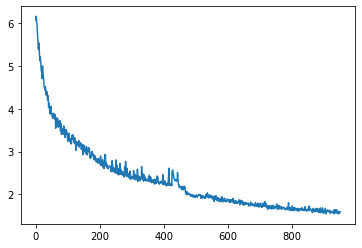

In [26]:
plt.plot(history.history['mae'][50:])

In [27]:
result = []
for i in models:
    result.append(i.predict(test_data))
predict = np.mean(result, axis = 0)

NameError: name 'models' is not defined

In [28]:
test_data.shape

(70596, 18)

In [29]:
submission["hold_d"] = model.predict(test_data)

In [30]:
submission["hold_d"] = np.round(submission["hold_d"]).astype('int')

In [31]:
submission

,submit_id,hold_d
0,IDX00001,180
1,IDX00002,394
2,IDX00003,164
3,IDX00004,278
4,IDX00005,11
...,...,...
70591,IDX70592,27
70592,IDX70593,122
70593,IDX70594,1017
70594,IDX70595,13


In [32]:
submission.to_csv("20211010_dnn1_1000.csv", index = False)

## 80.338